In [1]:
import matplotlib.colors as mcolors
import matplotlib.animation as ma
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from itertools import product
import pandas as pd
import numpy as np
import numba as nb
import imageio
import os
import shutil

randomSeed = 100

%matplotlib inline
%config InlineBackend.figure_format = "retina"

new_cmap = mcolors.LinearSegmentedColormap.from_list(
    "new", plt.cm.jet(np.linspace(0, 1, 256)) * 0.85, N=256
)

@nb.njit
def colors_idx(phaseTheta):
    return np.floor(256 - phaseTheta / (2 * np.pi) * 256).astype(np.int32)

import seaborn as sns

sns.set_theme(
    style="ticks", 
    font_scale=1.1, rc={
    'figure.figsize': (6, 5),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#000000',
    'figure.titleweight': "bold",
    'xtick.color': '#000000',
    'ytick.color': '#000000'
})

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['animation.ffmpeg_path'] = "/opt/conda/bin/ffmpeg"

from main import *
from multiprocessing import Pool
import pandas as pd

def get_ts_centers_no_mod(model: TwoOsillators):
    sa = StateAnalysis(model, classDistance=0.3, lookIndex=0)
    ts_centers = []
    for i in range(1, sa.totalPhaseTheta.shape[0]):
        positionx = sa.totalPositionX[i, :, 0]
        positiony = sa.totalPositionX[i, :, 1]
        pointTheta = sa.totalPointTheta[i, :]
        center = np.array([
            positionx - model.speedV * model.dt / pointTheta * np.sin(sa.totalPhaseTheta[i, :]),
            positiony + model.speedV * model.dt / pointTheta * np.cos(sa.totalPhaseTheta[i, :])
        ]).T
        ts_centers.append(center)
    ts_centers.insert(0, ts_centers[0])
    return np.array(ts_centers)

colors = ["#403990", "#80A6E2", "#FBDD85", "#F46F43", "#CF3D3E"]
cmap = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors)
cmap_r = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors[::-1])

In [2]:
model = TwoOsillators(
    strengthLambda=2, r0=1, typeA="distanceWgt", omega1=3, omega2=2.5, dt=0.01, couplesNum=1, 
    savePath="./data", overWrite=True, tqdm=True
)
model.run(2000)

  0%|          | 0/2000 [00:00<?, ?it/s]

(-5.0, 5.0)

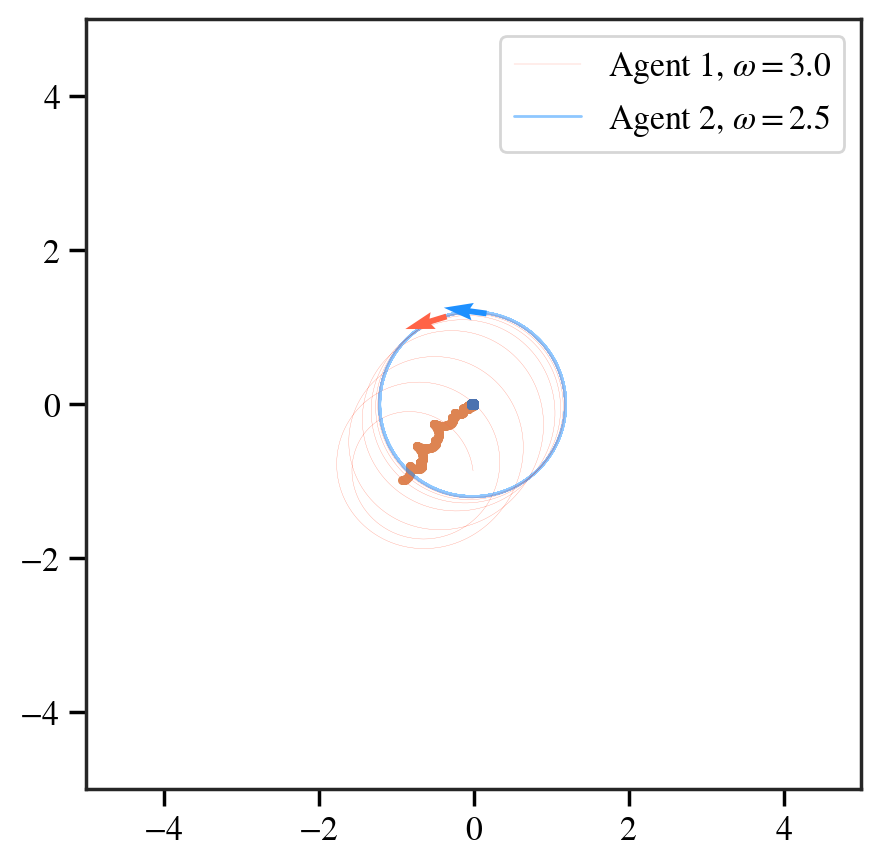

In [3]:
# model = models[1]
targetPath = f"./data/{model}.h5"
totalPositionX = pd.read_hdf(targetPath, key="positionX")
totalPhaseTheta = pd.read_hdf(targetPath, key="phaseTheta")
totalPointTheta = pd.read_hdf(targetPath, key="pointTheta")
TNum = totalPositionX.shape[0] // model.agentsNum
totalPositionX = totalPositionX.values.reshape(TNum, model.agentsNum, 2).transpose(0, 1, 2)
totalPhaseTheta = totalPhaseTheta.values.reshape(TNum, model.agentsNum)
totalPointTheta = totalPointTheta.values.reshape(TNum, model.agentsNum)
totalPointTheta[0] = np.nan
fig, ax = plt.subplots(figsize=(5, 5))
trajectoryLength = 0
plt.plot(totalPositionX[-trajectoryLength:, 0, 0], totalPositionX[-trajectoryLength:, 0, 1], color="tomato", alpha=0.8, lw=0.1)
plt.plot(totalPositionX[-trajectoryLength:, 1, 0], totalPositionX[-trajectoryLength:, 1, 1], color='dodgerblue', alpha=0.5, lw=1)
plt.quiver(
    totalPositionX[-1, 0, 0], totalPositionX[-1, 0, 1],
    np.cos(totalPhaseTheta[-1, 0]), np.sin(totalPhaseTheta[-1, 0]), color="tomato", zorder=10
)
plt.quiver(
    totalPositionX[-1, 1, 0], totalPositionX[-1, 1, 1],
    np.cos(totalPhaseTheta[-1, 1]), np.sin(totalPhaseTheta[-1, 1]), color="dodgerblue", zorder=10
)
plt.scatter(
    totalPositionX[:, 1, 0] - 3 * model.dt / totalPointTheta[:, 1] * np.sin(totalPhaseTheta[:, 1]),
    totalPositionX[:, 1, 1] + 3 * model.dt / totalPointTheta[:, 1] * np.cos(totalPhaseTheta[:, 1]), s=5, zorder=10
)
plt.scatter(
    totalPositionX[:, 0, 0] - 3 * model.dt / totalPointTheta[:, 0] * np.sin(totalPhaseTheta[:, 0]),
    totalPositionX[:, 0, 1] + 3 * model.dt / totalPointTheta[:, 0] * np.cos(totalPhaseTheta[:, 0]), s=5
)
plt.legend([fr"Agent 1, $\omega={model.omegaTheta[0]}$", fr"Agent 2, $\omega={model.omegaTheta[1]}$"])

bound = 5
plt.xlim(-bound, bound)
plt.ylim(-bound, bound)

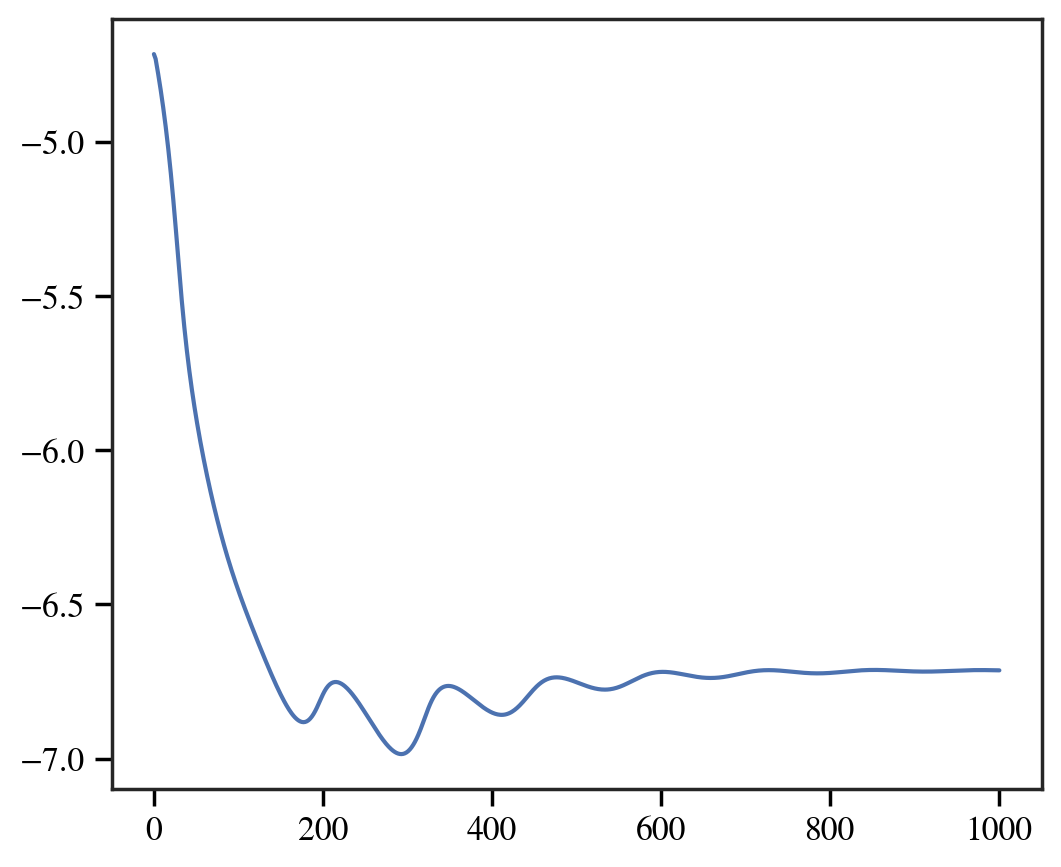

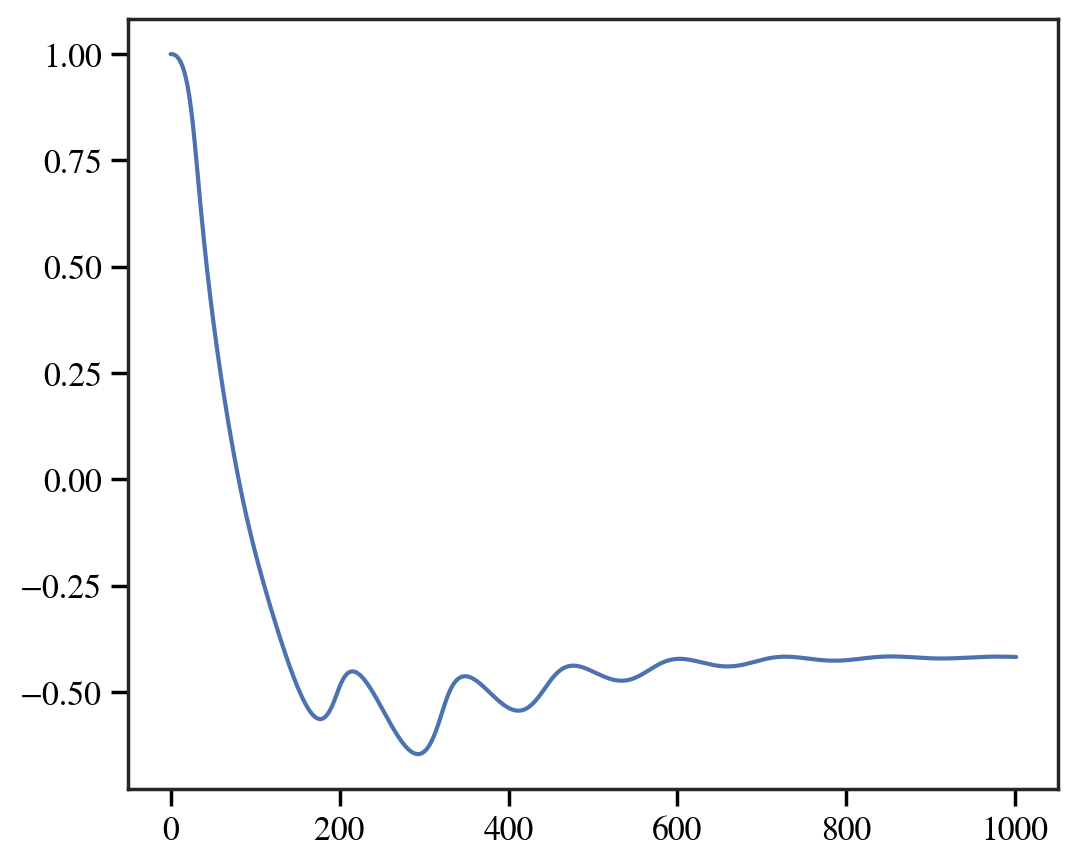

In [4]:
# plt.plot(totalPhaseTheta[:, 1] - totalPhaseTheta[:, 0])
rawDiff = totalPhaseTheta[:, 1] - totalPhaseTheta[:, 0]
# adjDiff = rawDiff.copy()
# # adjDiff[np.abs(rawDiff - np.roll(rawDiff, 1)) > np.pi * 0.9] = adjDiff[np.abs(rawDiff - np.roll(rawDiff, 1)) > np.pi * 0.9] - np.sign(rawDiff[np.abs(rawDiff - np.roll(rawDiff, 1)) > np.pi * 0.9]) * 2 * np.pi
# rate = 1
# # plt.plot(adjDiff)
# while np.any(np.abs(adjDiff - np.roll(adjDiff, 1)) > np.pi * rate):
#     print(np.sum(np.abs(adjDiff - np.roll(adjDiff, 1)) > np.pi * rate))
#     adjDiff[adjDiff - np.roll(adjDiff, 1) > np.pi * rate] = adjDiff[adjDiff - np.roll(adjDiff, 1) > np.pi * rate] - 2 * np.pi
#     adjDiff[adjDiff - np.roll(adjDiff, 1) < -np.pi * rate] = adjDiff[adjDiff - np.roll(adjDiff, 1) < -np.pi * rate] + 2 * np.pi
# plt.plot(adjDiff)
plt.plot(rawDiff)
plt.show()
plt.plot(np.sin(rawDiff))

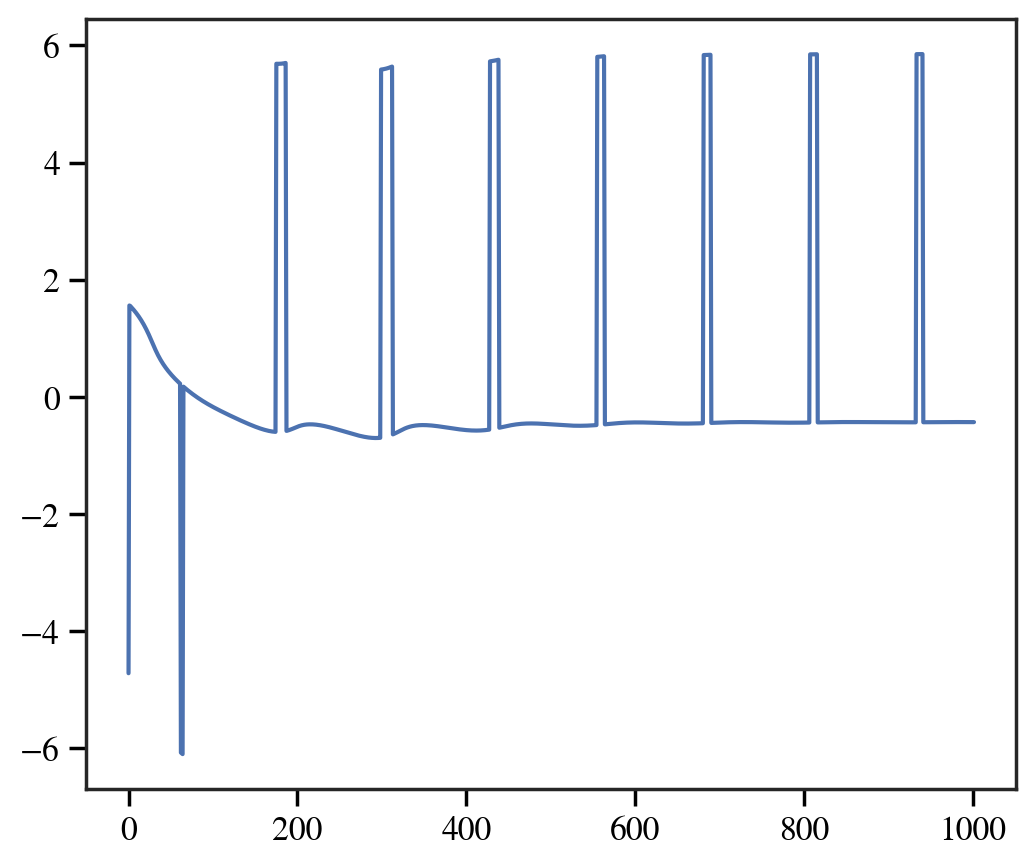

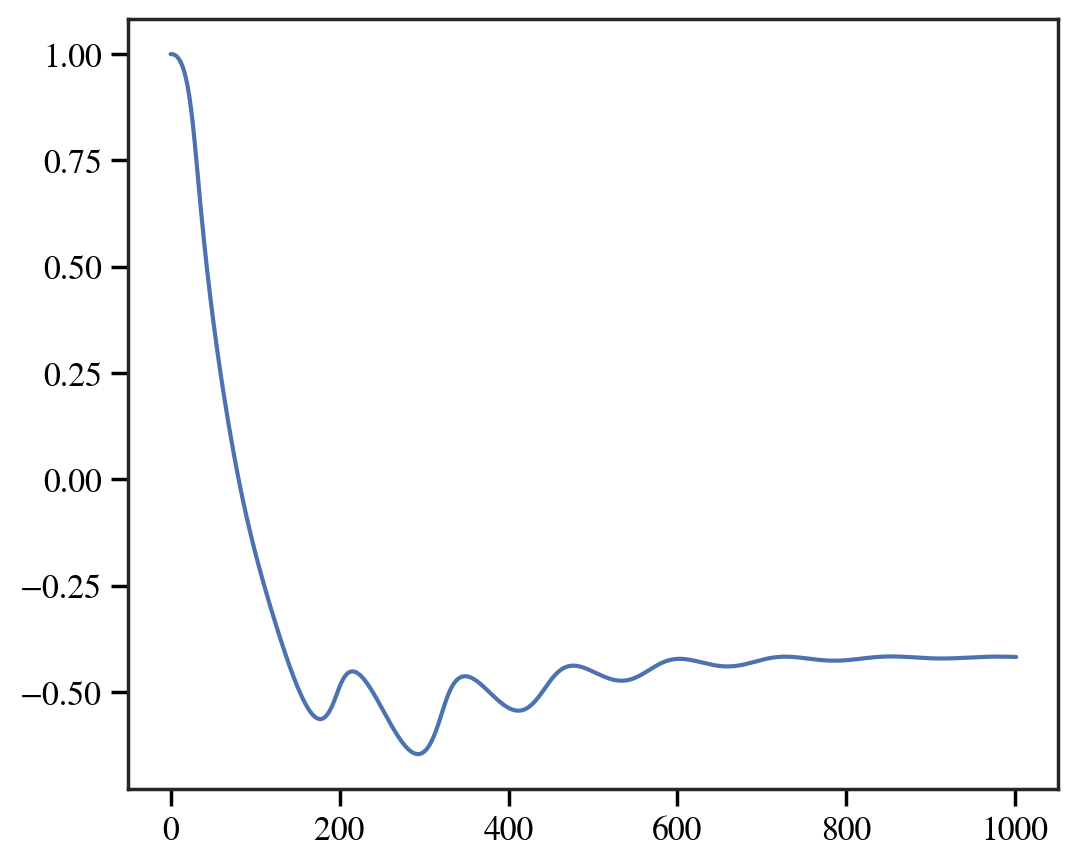

In [24]:
# plt.plot(totalPhaseTheta[:, 1] - totalPhaseTheta[:, 0])
rawDiff = totalPhaseTheta[:, 1] - totalPhaseTheta[:, 0]
# adjDiff = rawDiff.copy()
# # adjDiff[np.abs(rawDiff - np.roll(rawDiff, 1)) > np.pi * 0.9] = adjDiff[np.abs(rawDiff - np.roll(rawDiff, 1)) > np.pi * 0.9] - np.sign(rawDiff[np.abs(rawDiff - np.roll(rawDiff, 1)) > np.pi * 0.9]) * 2 * np.pi
# rate = 1
# # plt.plot(adjDiff)
# while np.any(np.abs(adjDiff - np.roll(adjDiff, 1)) > np.pi * rate):
#     print(np.sum(np.abs(adjDiff - np.roll(adjDiff, 1)) > np.pi * rate))
#     adjDiff[adjDiff - np.roll(adjDiff, 1) > np.pi * rate] = adjDiff[adjDiff - np.roll(adjDiff, 1) > np.pi * rate] - 2 * np.pi
#     adjDiff[adjDiff - np.roll(adjDiff, 1) < -np.pi * rate] = adjDiff[adjDiff - np.roll(adjDiff, 1) < -np.pi * rate] + 2 * np.pi
# plt.plot(adjDiff)
plt.plot(rawDiff)
plt.show()
plt.plot(np.sin(rawDiff))

In [10]:
adjDiff[adjDiff - np.roll(adjDiff, 1) < -np.pi * 1.9]

array([-6.0704214 , -0.58023949, -0.6395727 , -0.52630724, -0.46808096,
       -0.44376732, -0.43524991, -0.43246917])

In [11]:
adjDiff[adjDiff - np.roll(adjDiff, 1) < -np.pi * 0.9] + 2 * np.pi

array([1.56722312, 0.21276391, 5.70294582, 5.64361261, 5.75687807,
       5.81510434, 5.83941799, 5.8479354 , 5.85071614])

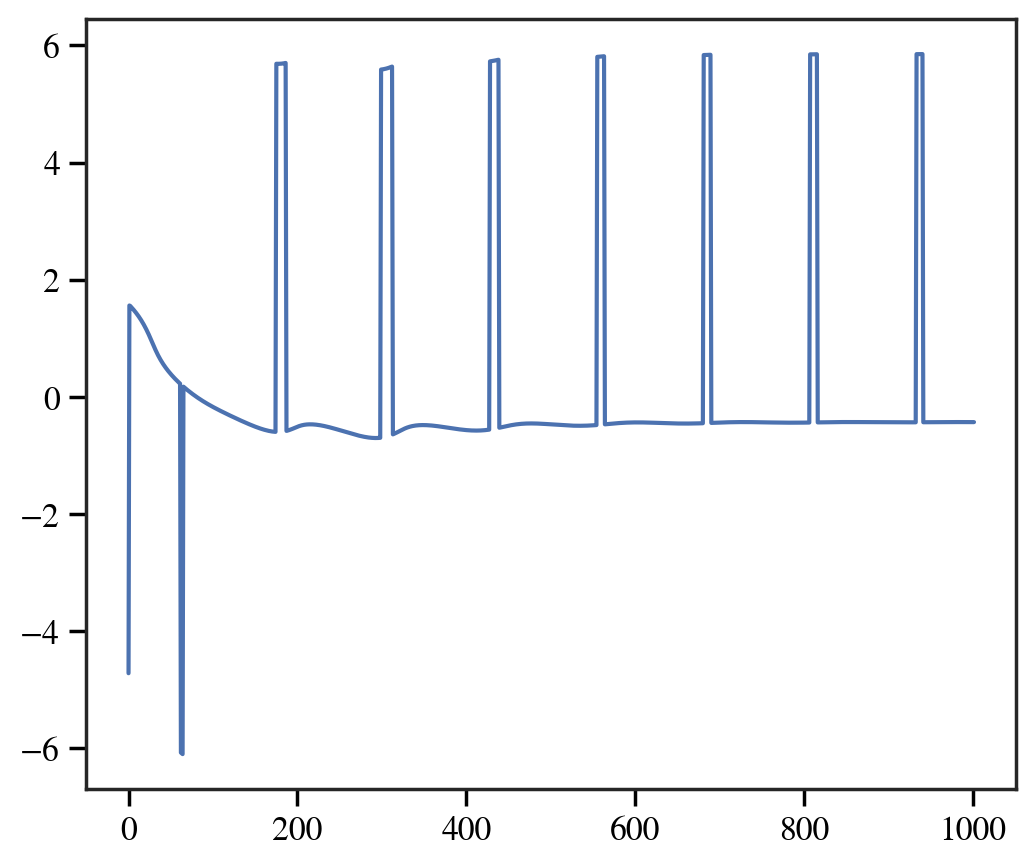

In [7]:
plt.plot(rawDiff)

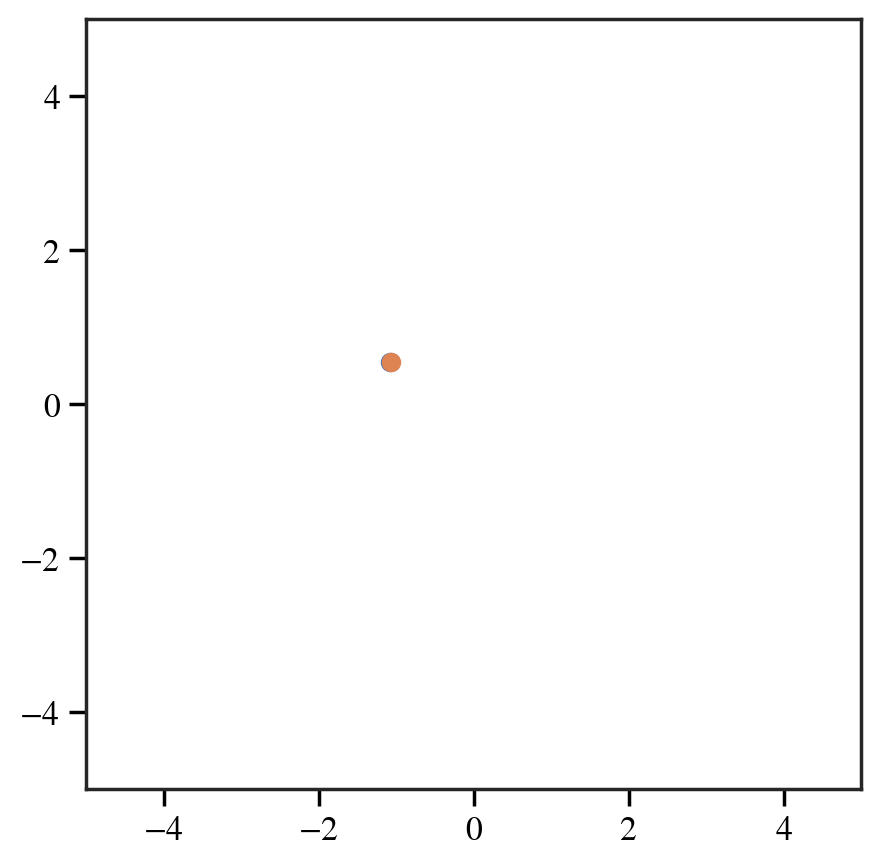

In [4]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(totalPositionX[-1, 1, 0], totalPositionX[-1, 1, 1])
plt.xlim(-bound, bound)
plt.ylim(-bound, bound)
# phi2 = np.arctan(totalPositionX[-trajectoryLength:, 1, 1] / totalPositionX[-trajectoryLength:, 1, 0])
phi2 = np.arctan2(totalPositionX[-1, 1, 1], totalPositionX[-1, 1, 0])
# phi2 = np.arctan2(totalPositionX[-trajectoryLength:, 1, 1], totalPositionX[-trajectoryLength:, 1, 0])
plt.scatter(np.cos(phi2) * 1.2, np.sin(phi2) * 1.2)

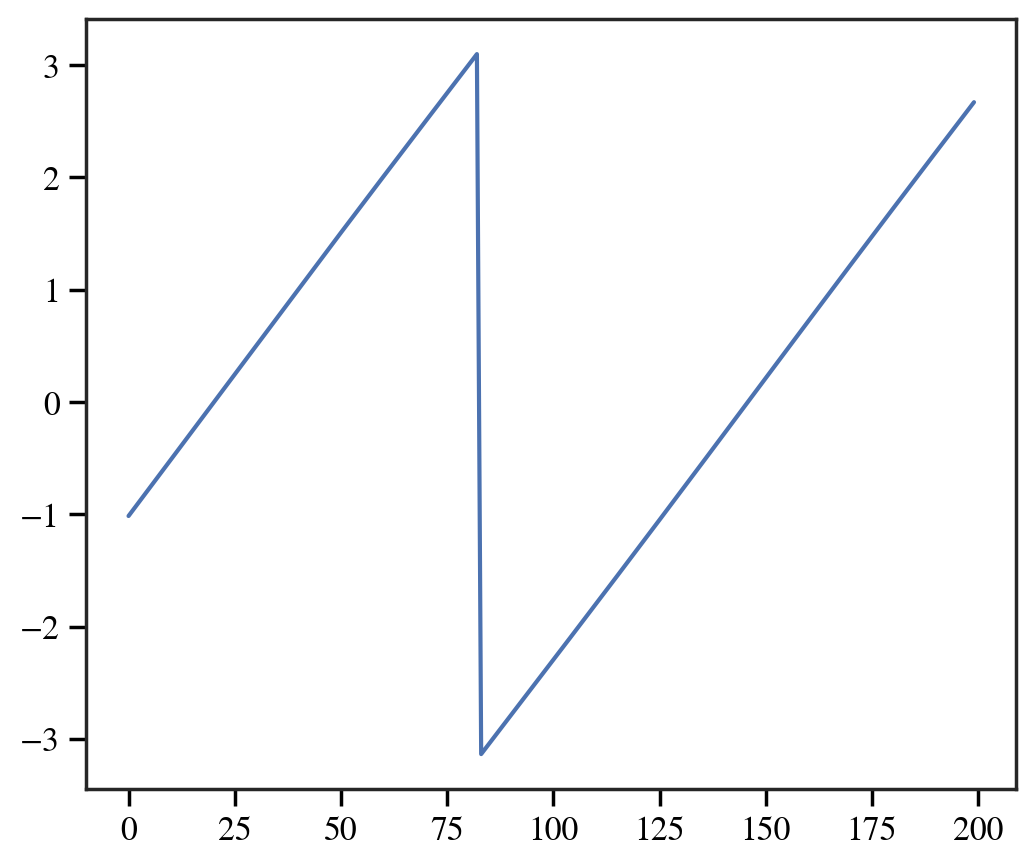

In [5]:
phi2 = np.arctan2(totalPositionX[-trajectoryLength:, 1, 1], totalPositionX[-trajectoryLength:, 1, 0])
plt.plot(phi2[-200:])
# phi2[-1], np.arctan2(totalPositionX[-1, 1, 1], totalPositionX[-1, 1, 0])

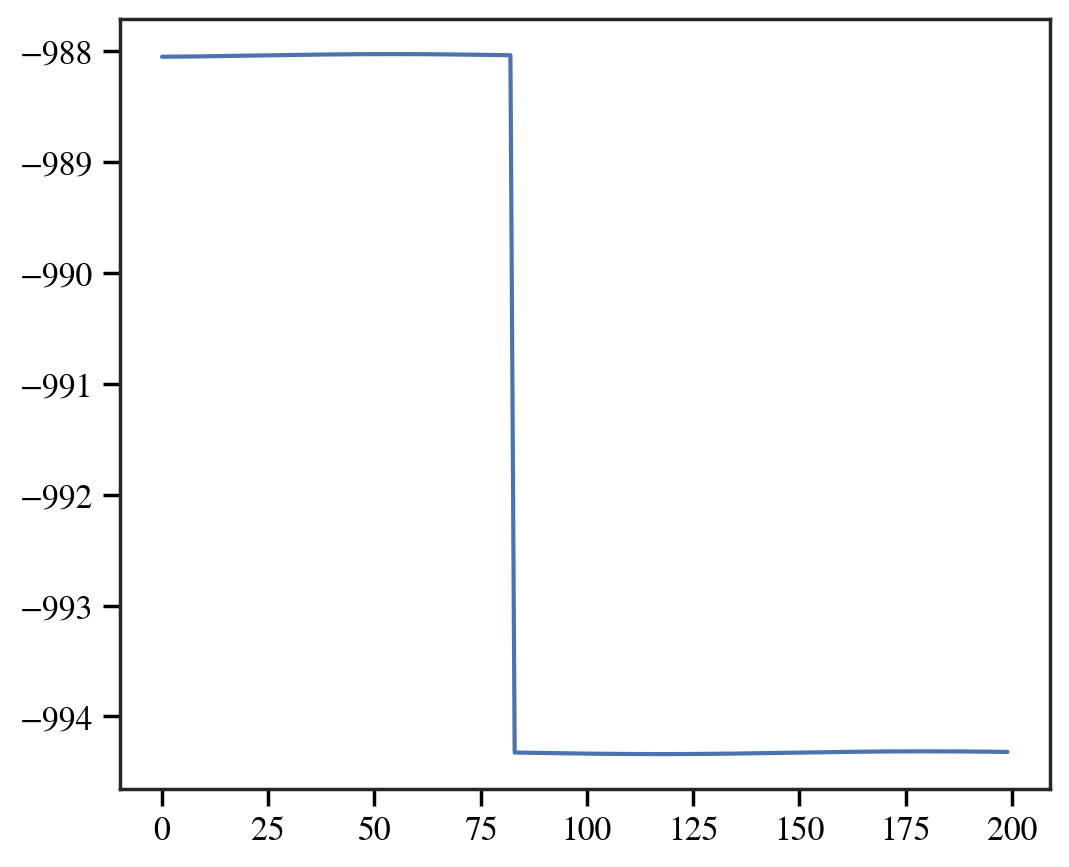

In [7]:
# plt.plot(totalPhaseTheta[-200:, 1])
totalPhaseTheta[-1, 1]
plt.plot(phi2[-200:] - totalPhaseTheta[-200:, 1])

In [47]:
np.pi / 2

1.5707963267948966

In [58]:
totalPhaseTheta[-1, 1] - phi2[-1]

1.175733813837613

(-5.0, 5.0)

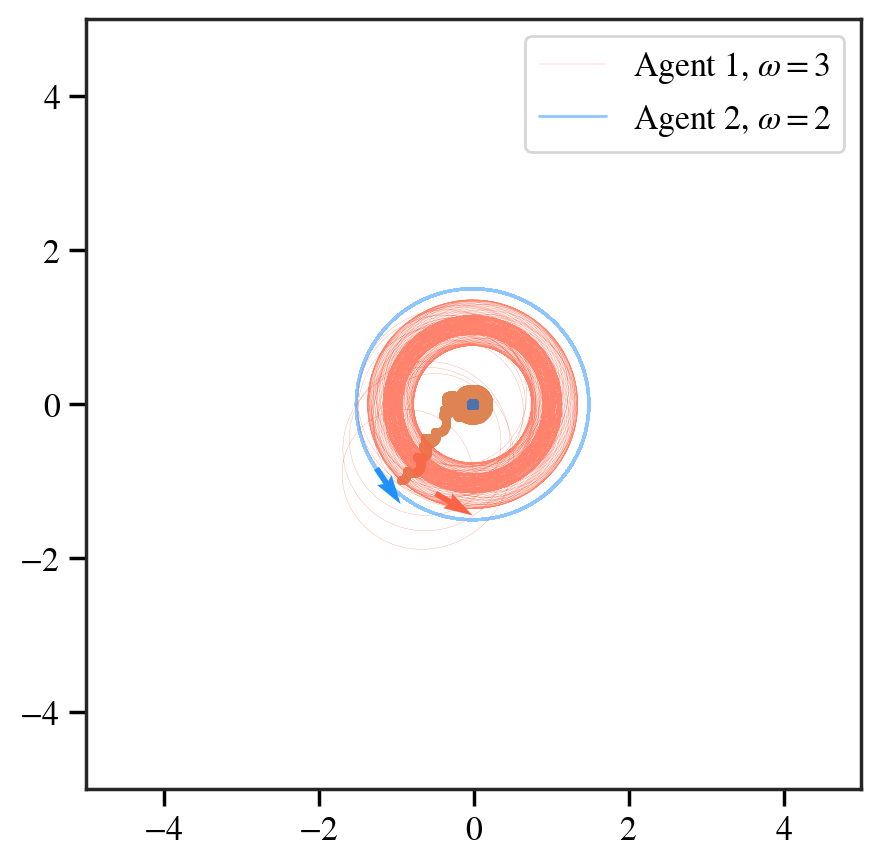

In [12]:
# model = models[1]
targetPath = f"./data/{model}.h5"
totalPositionX = pd.read_hdf(targetPath, key="positionX")
totalPhaseTheta = pd.read_hdf(targetPath, key="phaseTheta")
totalPointTheta = pd.read_hdf(targetPath, key="pointTheta")
TNum = totalPositionX.shape[0] // model.agentsNum
totalPositionX = totalPositionX.values.reshape(TNum, model.agentsNum, 2).transpose(0, 1, 2)
totalPhaseTheta = totalPhaseTheta.values.reshape(TNum, model.agentsNum)
totalPointTheta = totalPointTheta.values.reshape(TNum, model.agentsNum)
totalPointTheta[0] = np.nan
fig, ax = plt.subplots(figsize=(5, 5))
trajectoryLength = 0
plt.plot(totalPositionX[-trajectoryLength:, 0, 0], totalPositionX[-trajectoryLength:, 0, 1], color="tomato", alpha=0.8, lw=0.1)
plt.plot(totalPositionX[-trajectoryLength:, 1, 0], totalPositionX[-trajectoryLength:, 1, 1], color='dodgerblue', alpha=0.5, lw=1)
plt.quiver(
    totalPositionX[-1, 0, 0], totalPositionX[-1, 0, 1],
    np.cos(totalPhaseTheta[-1, 0]), np.sin(totalPhaseTheta[-1, 0]), color="tomato", zorder=10
)
plt.quiver(
    totalPositionX[-1, 1, 0], totalPositionX[-1, 1, 1],
    np.cos(totalPhaseTheta[-1, 1]), np.sin(totalPhaseTheta[-1, 1]), color="dodgerblue", zorder=10
)
plt.scatter(
    totalPositionX[:, 1, 0] - 3 * model.dt / totalPointTheta[:, 1] * np.sin(totalPhaseTheta[:, 1]),
    totalPositionX[:, 1, 1] + 3 * model.dt / totalPointTheta[:, 1] * np.cos(totalPhaseTheta[:, 1]), s=5, zorder=10
)
plt.scatter(
    totalPositionX[:, 0, 0] - 3 * model.dt / totalPointTheta[:, 0] * np.sin(totalPhaseTheta[:, 0]),
    totalPositionX[:, 0, 1] + 3 * model.dt / totalPointTheta[:, 0] * np.cos(totalPhaseTheta[:, 0]), s=5
)
plt.legend([fr"Agent 1, $\omega={model.omegaTheta[0]}$", fr"Agent 2, $\omega={model.omegaTheta[1]}$"])

bound = 5
plt.xlim(-bound, bound)
plt.ylim(-bound, bound)

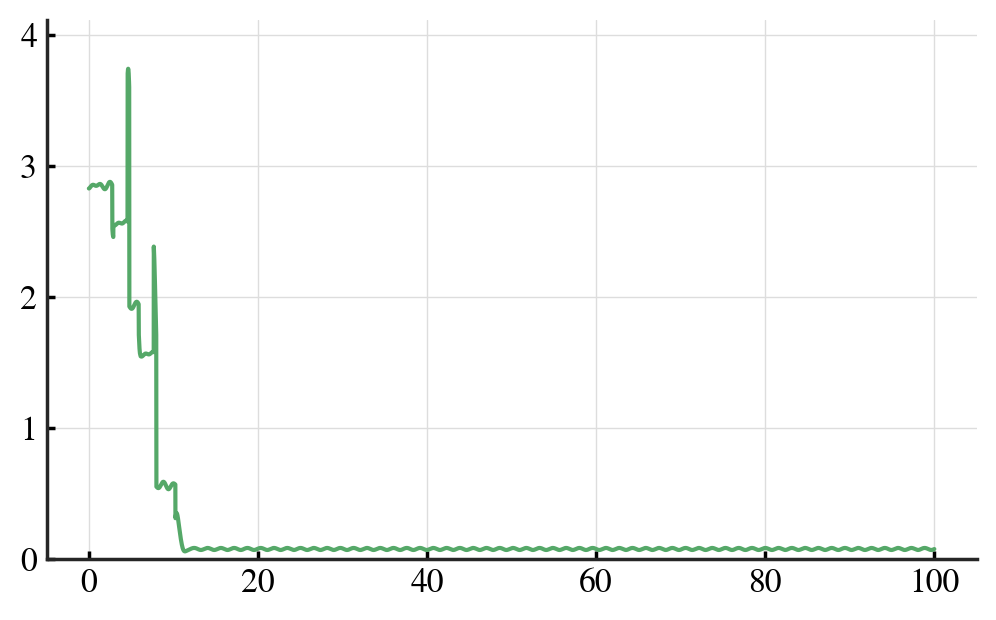

In [4]:
plt.subplots(1, 1, figsize=(6, 3.5))
colorIdx = 2

targetPath = f"./data/{model}.h5"
totalPositionX = pd.read_hdf(targetPath, key="positionX")
totalPhaseTheta = pd.read_hdf(targetPath, key="phaseTheta")
totalPointTheta = pd.read_hdf(targetPath, key="pointTheta")
TNum = totalPositionX.shape[0] // model.agentsNum
totalPositionX = totalPositionX.values.reshape(TNum, model.agentsNum, 2)
totalPhaseTheta = totalPhaseTheta.values.reshape(TNum, model.agentsNum)
totalPointTheta = totalPointTheta.values.reshape(TNum, model.agentsNum)
tsCentersNoMod = get_ts_centers_no_mod(model)
sub = tsCentersNoMod[:, 0] - tsCentersNoMod[:, 1]
distance = np.sqrt(np.sum(sub ** 2, axis=1))
omega1, omega2 = model.omegaTheta
x = np.arange(len(distance)) * model.dt
plt.plot(x, distance, color=f"C{colorIdx}",
            label=fr"$d_0={model.r0}, \omega_1={omega1}, \omega_2={omega2}$")
# plt.axline((0, model.distanceD0 + np.sum(3 / np.abs(model.omegaTheta))), slope=0, 
#             color=f"C{colorIdx}", linestyle="--", alpha=0.8, lw=1)
colorIdx += 1
plt.ylim(0, distance.max() * 1.1)

plt.tick_params(direction='in', length=3)
plt.grid(True)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

In [1]:
from sympy import symbols, Eq, Function, sin, cos, diff, Matrix, sqrt, latex, simplify, sign, pi

# 定义符号变量
t = symbols('t')
f, v, r_1, omega_1, lamda, r_2, Delta_phi, omega_2, Delta_omega, Delta_theta = symbols('f v r_1 omega_1 lamda r_2 Delta_phi omega_2 Delta_omega Delta_theta')
r_1 = Function('r_1')(t)
Delta_phi = Function('Delta_phi')(t)
Delta_theta = Function('Delta_theta')(t)
f = Function('f')(r_1, r_2, Delta_phi)
alpha_2 = symbols("alpha_2")# -pi * sign(omega_2) / 2

# 定义未知函数
r_1_dot = r_1.diff(t)
Delta_phi_dot = Delta_phi.diff(t)
Delta_theta_dot = Delta_theta.diff(t)

# 定义方程组
eq1 = Eq(r_1_dot, v*cos(Delta_phi + Delta_theta + alpha_2))
eq2 = Eq(Delta_phi_dot, omega_2 - v/r_1*sin(Delta_phi + Delta_theta + alpha_2))
eq3 = Eq(Delta_theta_dot, Delta_omega - lamda*f*sin(Delta_theta))

# 打印方程组
print("动力学方程组:")
print(eq1)
print(eq2)
print(eq3)

动力学方程组:
Eq(Derivative(r_1(t), t), v*cos(alpha_2 + Delta_phi(t) + Delta_theta(t)))
Eq(Derivative(Delta_phi(t), t), omega_2 - v*sin(alpha_2 + Delta_phi(t) + Delta_theta(t))/r_1(t))
Eq(Derivative(Delta_theta(t), t), Delta_omega - lamda*f(r_1(t), r_2, Delta_phi(t))*sin(Delta_theta(t)))


In [19]:
M = Matrix([
    [diff(eq.rhs, var) for var in [r_1, Delta_phi, Delta_theta]]
    for eq in [eq1, eq2, eq3]
])
M

Matrix([
[                                                                          0,                                   -v*sin(alpha_2 + Delta_phi(t) + Delta_theta(t)),         -v*sin(alpha_2 + Delta_phi(t) + Delta_theta(t))],
[                   v*sin(alpha_2 + Delta_phi(t) + Delta_theta(t))/r_1(t)**2,                            -v*cos(alpha_2 + Delta_phi(t) + Delta_theta(t))/r_1(t),  -v*cos(alpha_2 + Delta_phi(t) + Delta_theta(t))/r_1(t)],
[-lamda*sin(Delta_theta(t))*Derivative(f(r_1(t), r_2, Delta_phi(t)), r_1(t)), -lamda*sin(Delta_theta(t))*Derivative(f(r_1(t), r_2, Delta_phi(t)), Delta_phi(t)), -lamda*f(r_1(t), r_2, Delta_phi(t))*cos(Delta_theta(t))]])

In [3]:
CDelta, r_0 = symbols(r'C_{\Delta} r_0')
f, g = symbols('f g')
# f = (1 + v * sqrt(2 - 2*cos(CDeltaPhi)) / abs(omega_2) / r_0) ** (-1 / r_0)
# g = -abs(omega_2) * (1 + v * sqrt(2 - 2*cos(CDeltaPhi)) / abs(omega_2) / r_0) ** (-1 / r_0 - 1) / v / sqrt(2 - 2*cos(CDeltaPhi)) / r_0**2

# -omega_2**2 / v * sign(omega_2) - lamda*v/omega_2*g*sin(CDeltaTheta)
# - lamda*v**2/omega_2*g*sin(CDeltaTheta)*sin(CDeltaPhi)
# -lamda * f * cos(CDeltaTheta)

In [8]:
fr1, fDeltaPhi, f, l, K = symbols(r'f_{r1} f_{\Delta\varphi} f \lambda K')
deltaOmega = symbols(r'\Delta\omega')
Mnew = Matrix([
    [0, v * sign(omega_2), v * sign(omega_2)],
    [-omega_2**2 / v * sign(omega_2), 0, 0],
    [-deltaOmega*fr1/f, deltaOmega*fDeltaPhi/f, K * f * sqrt(1 - (deltaOmega / K/f)**2)]
])
a, b, c, d, h = symbols('a b c d h')
# Mnew = Matrix([
#     [0, a, a],
#     [b, 0, 0],
#     [c, d, h]
# ])
Mnew
# print(latex(Mnew.det()))

Matrix([
[                          0,                  v*sign(omega_2),                           v*sign(omega_2)],
[-omega_2**2*sign(omega_2)/v,                                0,                                         0],
[     -\Delta\omega*f_{r1}/f, \Delta\omega*f_{\Delta\varphi}/f, K*f*sqrt(1 - \Delta\omega**2/(K**2*f**2))]])

In [53]:
fr1, fDeltaPhi, f, l, K = symbols(r'f_{r1} f_{\Delta\varphi} f \lambda K')
Meig = Matrix([
    [l, 0, 0],
    [0, l, 0],
    [0, 0, l]
]) - Matrix([
    [0, v * sign(omega_2), v * sign(omega_2)],
    [-omega_2**2 / v * sign(omega_2), 0, 0],
    [-K*fr1*sin(CDelta), -K*fDeltaPhi*sin(CDelta), -K * f * cos(CDelta)]
])
# Mnew = Matrix([
#     [0, a, a],
#     [b, 0, 0],
#     [c, d, h]
# ])

# 求Meig的行列式并整理成关于l的多项式
detMeig = Meig.det().expand()
# print(latex(detMeig))
Meig

Matrix([
[                   \lambda,                    -v*sign(omega_2),              -v*sign(omega_2)],
[omega_2**2*sign(omega_2)/v,                             \lambda,                             0],
[  K*f_{r1}*sin(C_{\Delta}), K*f_{\Delta\varphi}*sin(C_{\Delta}), K*f*cos(C_{\Delta}) + \lambda]])

In [29]:
# 求Mnew的行列式值
Mnew.det().simplify()

Piecewise((0, Eq(omega_2, 0)), (lamda*omega_2**4*(f*cos(C_{\Delta}) - f_{\Delta\phi}*sin(C_{\Delta}))/Abs(omega_2**2), True))

In [22]:
# 求解Mnew的特征值
eigs = Mnew.eigenvals()

In [121]:
v = 3
omega2 = 3
absDeltaOmega = 0.1
DeltaPhi = 1e-5

lamda = 0.5
r0 = 1
f = (1 + v * np.sqrt(2 - 2 * np.cos(DeltaPhi)) / np.abs(omega2) / r_0) ** (-1 / r0)
g = - np.abs(omega2) * f**(1 + r0) / (v * r0**2 * np.sqrt(2 - 2 * np.cos(DeltaPhi)))
m12 = v * np.sign(omega2)
m21 = - omega2**2 / v * np.sign(omega2)
m31 = - lamda * v / np.abs(omega2) * g * np.sin(DeltaPhi)
m32 = lamda * v**2 / omega2**2 * g * np.sin(DeltaPhi)**2
m33 = - lamda * f * np.cos(DeltaPhi)
matrix = np.array([
    [0, m12, m12],
    [m21, 0, 0],
    [m31, m32, m33]
])
eigenvalues = np.linalg.eigvals(matrix)
print(eigenvalues)

[ 0.04773832+2.74856413j  0.04773832-2.74856413j -0.59547165+0.j        ]


In [122]:
lamda * f, lamda, f

(0.49999500004979264, 0.5, 0.9999900000995853)

In [13]:
def get_2_maps(lamdaRange: np.ndarray, r0Range: np.ndarray, 
               v: float, omega2: float, absDeltaOmega: float, DeltaPhi: float):

    classMap = np.zeros((len(lamdaRange), len(r0Range)))
    fixPointMap = np.zeros((len(lamdaRange), len(r0Range)))

    for lamdaIdx, lamda in enumerate(lamdaRange):
        for r0Idx, r0 in enumerate(r0Range):
            f = (1 + v * np.sqrt(2 - 2 * np.cos(DeltaPhi)) / np.abs(omega2) / r0) ** (-1 / r0)
            g = - np.abs(omega2) * f**(1 + r0) / (v * r0**2 * np.sqrt(2 - 2 * np.cos(DeltaPhi)))
            m12 = v * np.sign(omega2)
            m21 = - omega2**2 / v * np.sign(omega2)
            m31 = - lamda * v / np.abs(omega2) * g * np.sin(DeltaPhi)
            m32 = lamda * v**2 / omega2**2 * g * np.sin(DeltaPhi)**2
            m33 = - lamda * f * np.cos(DeltaPhi)
            matrix = np.array([
                [0, m12, m12],
                [m21, 0, 0],
                [m31, m32, m33]
            ])
            eigenvalues = np.linalg.eigvals(matrix)
            if lamda * f < absDeltaOmega:  # escape
                fixPointMap[lamdaIdx, r0Idx] = 0
            else:
                fixPointMap[lamdaIdx, r0Idx] = 1
            if np.all(np.real(eigenvalues) < 0):  # stable
                if np.any(np.imag(eigenvalues) != 0):  # stable focus
                    classMap[lamdaIdx, r0Idx] = 1
                else:  # stable node
                    classMap[lamdaIdx, r0Idx] = 2
            elif np.all(np.real(eigenvalues) > 0):  # unstable
                if np.any(np.imag(eigenvalues) != 0):  # unstable focus
                    classMap[lamdaIdx, r0Idx] = 3
                else:  # unstable node
                    classMap[lamdaIdx, r0Idx] = 4
            else:  # saddle
                if np.sum(np.sign(np.real(eigenvalues)) == 1) == 2:
                    classMap[lamdaIdx, r0Idx] = 2.5
                else:
                    classMap[lamdaIdx, r0Idx] = 5

    return classMap, fixPointMap

v = 3
omega2 = 2
absDeltaOmega = 0.10
lamdaRange = np.linspace(0, 2, 100)
r0Range = np.linspace(0.01, 5, 100)
DeltaPhi = np.pi / 12  # np.pi / 12
classMap, fixPointMap = get_2_maps(lamdaRange, r0Range, v, omega2, absDeltaOmega, DeltaPhi)
maxLambdas = []
for r0Idx, r0 in enumerate(r0Range):
    maxLambda = np.max(lamdaRange[fixPointMap[:, r0Idx] == 0])
    maxLambdas.append(maxLambda)

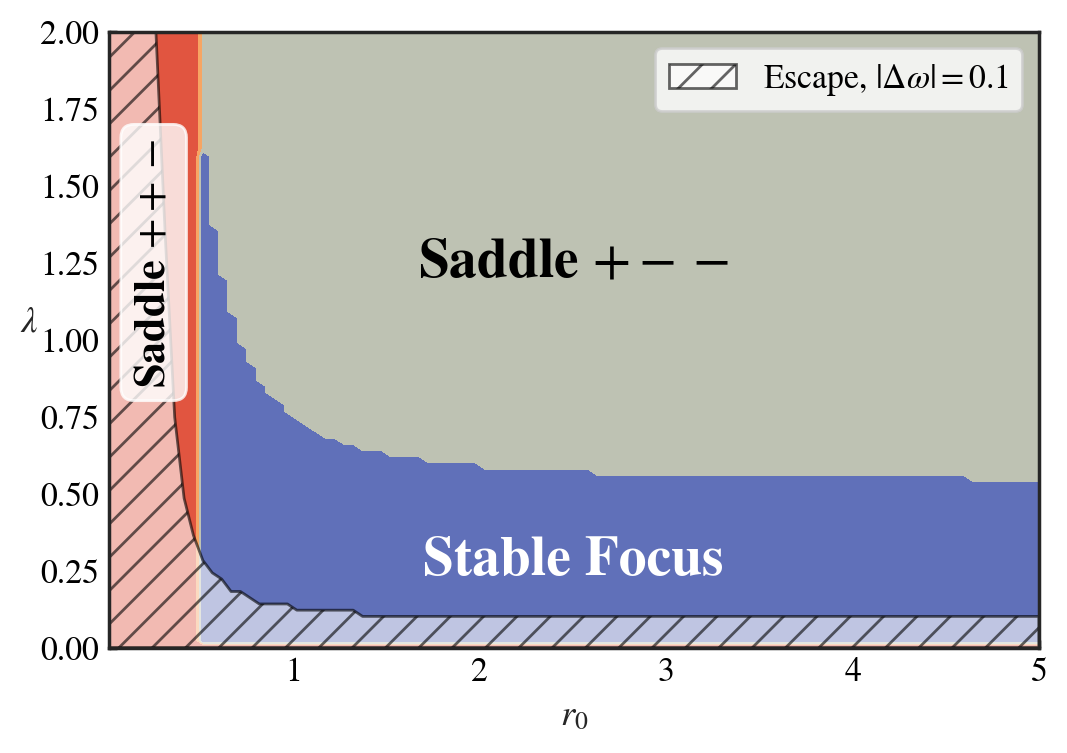

In [39]:
plt.figure(figsize=(6, 4))
plt.contourf(
    r0Range, lamdaRange, classMap, levels=len(np.unique(classMap)),
    cmap=cmap, alpha=1, 
)
plt.fill_between(r0Range, 0, maxLambdas, color="white", alpha=0.6, hatch="//", 
                 edgecolor="black", label=rf"Escape, $|\Delta\omega|={absDeltaOmega}$")
bbox_style = {
    'boxstyle': 'round',  # 文本框形状为圆角矩形
    'facecolor': 'white',  # 背景颜色为黄色
    'alpha': 0.8  # 透明度为0.5
}
plt.text(2.5, 0.28, "Stable Focus", color='white', fontsize=20, ha="center", va="center", fontweight="bold")
plt.text(2.5, 1.25, r"Saddle $+--$", color='black', fontsize=20, ha="center", va="center", fontweight="bold")
plt.text(0.25, 1.25, r"Saddle $++-$", color='black', fontsize=16, ha="center", va="center", fontweight="bold", 
         rotation=90, bbox=bbox_style)
# df = pd.DataFrame(classMap, index=lamdaRange, columns=r0Range)[::-1]
# df.index = np.round(df.index, 1)
# df.columns = np.round(df.columns, 2)
# sns.heatmap(df, xticklabels=10, yticklabels=10, cmap=cmap, cbar=False)
plt.xlabel(r"$r_0$")
plt.ylabel(r"$\lambda$", rotation=0)
plt.tick_params(direction='in', length=3)
plt.legend()
plt.show()

In [454]:
absDeltaOmegaRange = np.linspace(0.1, np.pi, 20)

v = 3
omega2 = 2
DeltaPhi = np.pi / 12
lamdaRange = np.linspace(0, 2, 100)
r0Range = np.linspace(0.01, 5, 100)

totalPositionsFixPoint = []

for absDeltaOmega in absDeltaOmegaRange:
    classMap, fixPointMap = get_2_maps(lamdaRange, r0Range, v, omega2, absDeltaOmega, DeltaPhi)
    maxLambdas = []
    for r0Idx, r0 in enumerate(r0Range):
        maxLambda = np.max(lamdaRange[fixPointMap[:, r0Idx] == 0])
        maxLambdas.append(maxLambda)
    positions = np.array([maxLambdas, r0Range])
    positions = np.concatenate([positions, [np.ones(positions.shape[1]) * absDeltaOmega]]).T
    totalPositionsFixPoint.append(positions)

totalPositionsFixPoint = np.array(totalPositionsFixPoint)

totalPositionsClass = []
DeltaPhiRange = np.linspace(0.1, np.pi / 2, 20)

for DeltaPhi in DeltaPhiRange:
    classMap, fixPointMap = get_2_maps(lamdaRange, r0Range, v, omega2, absDeltaOmega, DeltaPhi)
    maxLambdas = []
    for r0Idx, r0 in enumerate(r0Range):
        saddleIdx = np.where(classMap[:, r0Idx] < 5)
        if len(saddleIdx[0]) == 0:
            maxLambda = 0
        else:
            maxLambda = np.max(saddleIdx)
        maxLambdas.append(maxLambda)
    positions = np.array([maxLambdas, r0Range])
    positions = np.concatenate([positions, [np.ones(positions.shape[1]) * DeltaPhi]]).T
    totalPositionsClass.append(positions)

totalPositionsClass = np.array(totalPositionsClass)

Text(0.5, 0, '$|\\Delta\\omega|$')

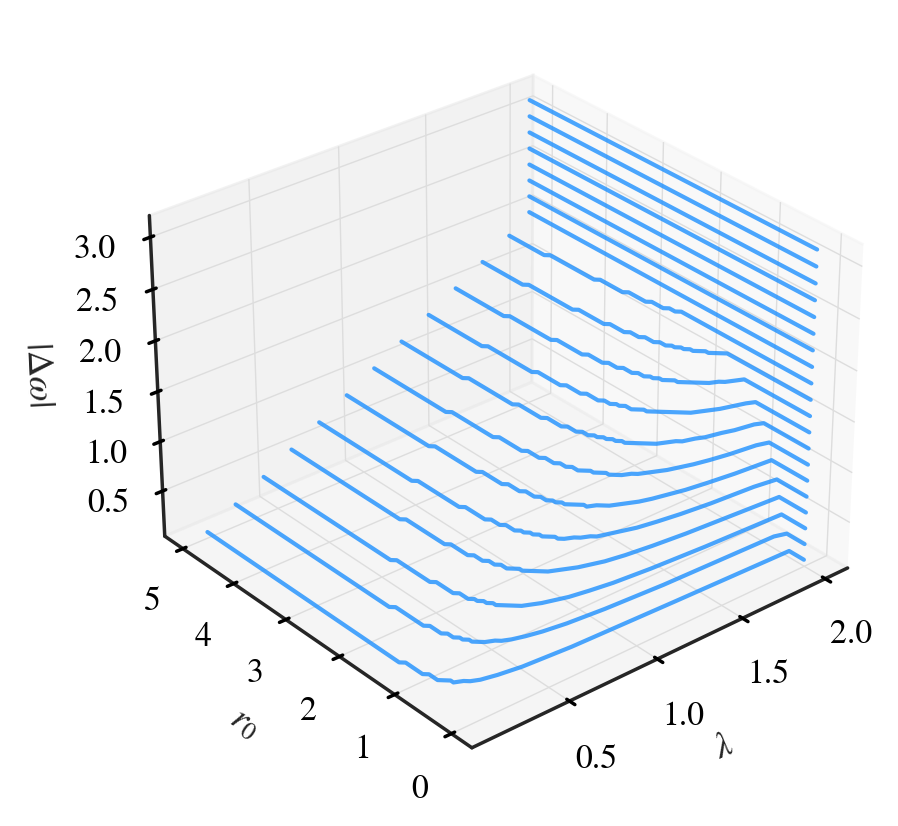

In [426]:
# 画3D图
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')
concatPositions = np.concatenate(totalPositionsFixPoint)
# 转换为曲面要求的格式
x = lamdaRange
y = r0Range
z = np.zeros((len(x), len(y)))
# for l, r in product(lamdaRange, r0Range):
#     idxs = np.where(np.isclose(concatPositions[:, :2], [l, r]).all(axis=1))[0]
#     if len(idxs) > 0:
#         l, r, o = concatPositions[idxs[0]]
#         xIdx, yIdx = np.where(np.isclose(x, l))[0][0], np.where(np.isclose(y, r))[0][0]
#         z[xIdx, yIdx] = o

for positions in totalPositionsFixPoint:
    ax.plot(positions[:, 0], positions[:, 1], positions[:, 2], color='dodgerblue', alpha=0.8)
    # ax.plot_surface
# ax.plot_surface(x, y, z, cmap=new_cmap, alpha=0.8)
# ax.plot_trisurf(concatPositions[:, 0], concatPositions[:, 1], concatPositions[:, 2], cmap=new_cmap, alpha=0.8)
ax.view_init(30, 230)
ax.set_xlabel(r"$\lambda$")
ax.set_ylabel(r"$r_0$")
ax.set_zlabel(r"$|\Delta\omega|$")

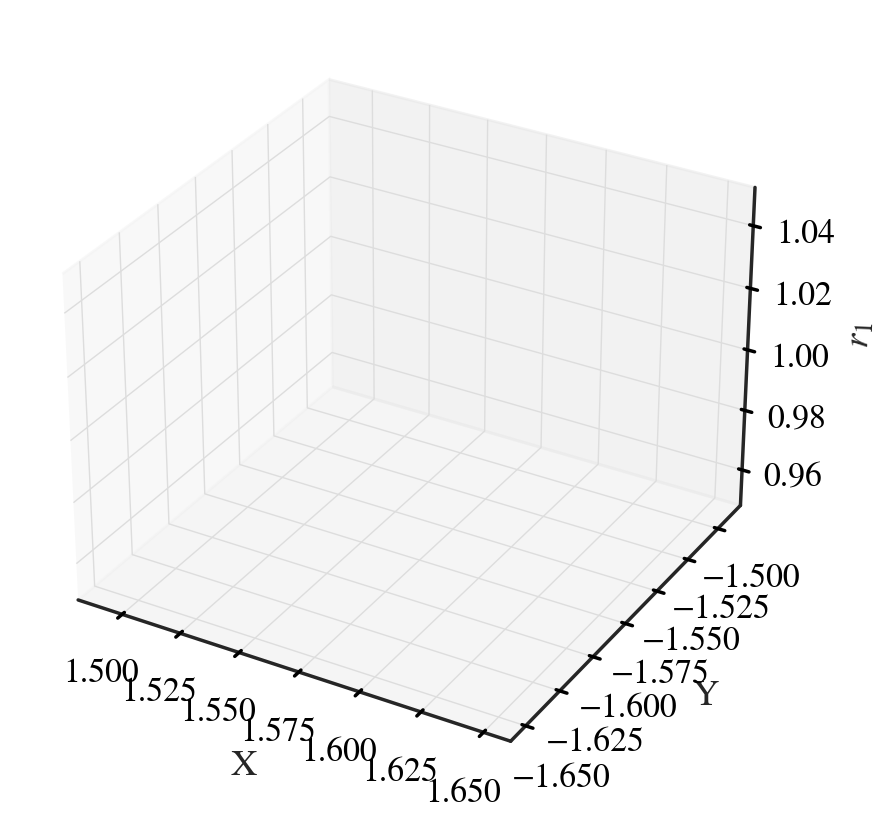

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 设置参数网格
u = np.linspace(0, 2*np.pi, 50)
v = np.linspace(0, np.pi, 50)

# 生成网格
U, V = np.meshgrid(u, v)

vDivOmega2 = 1
cDelta = np.pi / 2

# 计算参数方程的值
x = cDelta * np.ones_like(U)
y = -cDelta * np.ones_like(U)
z = vDivOmega2 * np.ones_like(U)

# 创建三维坐标轴
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 绘制曲面
ax.plot_surface(x, y, z, rstride=1, cstride=1, cmap='viridis')

# 设置坐标轴标签和标题
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel(r"$r_1$", rotation=90)

# 显示图形
plt.show()

In [158]:
import numpy as np
import numba as nb

class TwoOsillators:
    def __init__(self, K: float, r0: float, omega2: float, omega1: float, 
                 v: float = 3, dt: float = 0.01) -> None:   
        self.K = K
        self.alpha2 = -np.pi * np.sign(omega2) / 2
        self.r0 = r0
        self.omega2 = omega2
        self.omega1 = omega1
        self.v = v
        self.deltaOmega = omega2 - omega1
        self.r2 = self.v / np.abs(self.omega2)
        self.dt = dt

    def f(self, r1: float, deltaPhi: float):
        r = np.sqrt(r1**2 + self.r2**2 - 2 * r1 * self.r2 * np.cos(deltaPhi))
        return np.exp(-r / self.r0)

    def point(self, r1: float, deltaPhi: float, deltaTheta: float):
        return (
            self.v * np.cos(deltaTheta - deltaPhi + self.alpha2),
            self.omega2 - self.v / r1 * np.sin(deltaTheta - deltaPhi + self.alpha2),
            self.deltaOmega - self.K * self.f(r1, deltaPhi) * np.sin(deltaTheta)
        )

    def get_trajectories(self, initState: np.ndarray, iterations=100):
        r1, deltaPhi, deltaTheta = [initState[0]], [initState[1]], [initState[2]]
        for _ in range(iterations):
            r1T, deltaPhiT, deltaThetaT = r1[-1], deltaPhi[-1], deltaTheta[-1]
            r1K1, deltaPhiK1, deltaThetaK1 = self.point(r1T, deltaPhiT, deltaThetaT)
            r1.append(r1T + self.dt * r1K1 * (r1T + self.dt * r1K1 > 0))
            deltaPhi.append(np.mod(deltaPhiT + self.dt * deltaPhiK1 + np.pi, 2 * np.pi) - np.pi)
            deltaTheta.append(np.mod(deltaThetaT + self.dt * deltaThetaK1 + np.pi, 2 * np.pi) - np.pi)
        return np.array([r1, deltaPhi, deltaTheta])

In [159]:
model = TwoOsillators(K=2, r0=1, omega2=3, omega1=2.5)
initState = np.array([1.2 * 2, 1, 1])
trajectories = model.get_trajectories(initState, 40000)

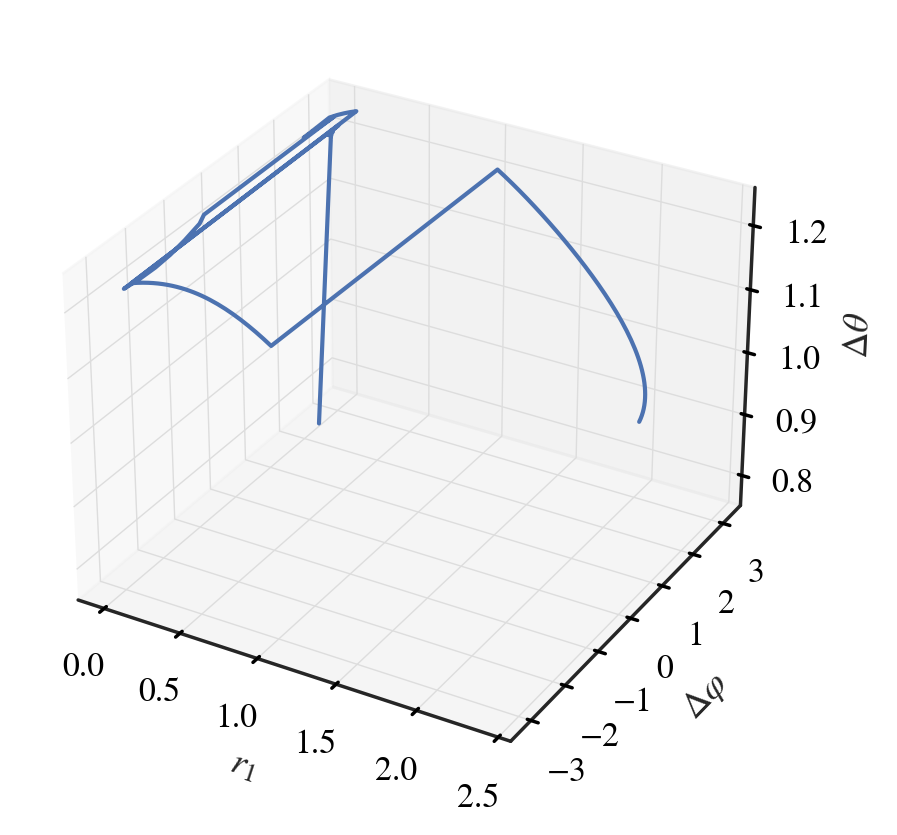

In [160]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(trajectories[0], trajectories[1], trajectories[2])
ax.set_xlabel(r"$r_1$")
ax.set_ylabel(r"$\Delta\varphi$")
ax.set_zlabel(r"$\Delta\theta$")
plt.show()

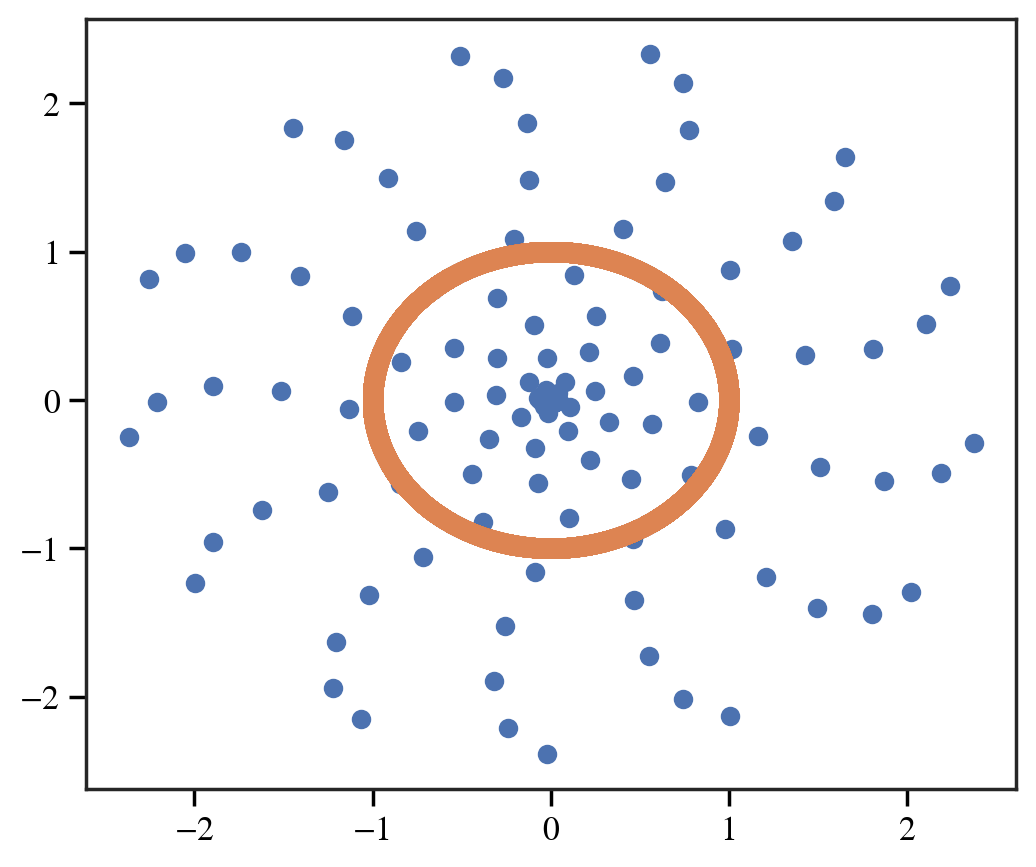

In [161]:
r1, deltaPhi, deltaTheta = trajectories
alpha1 = deltaTheta - deltaPhi + model.alpha2
theta2 = 2 + model.omega2 * 1000 * np.arange(len(r1)) * model.dt
phi2 = model.alpha2 + theta2
theta1 = theta2 - deltaTheta
phi1 = alpha1 + theta1
x1 = r1 * np.cos(phi1)
y1 = r1 * np.sin(phi1)
x2 = model.r2 * np.cos(theta2)
y2 = model.r2 * np.sin(theta2)
idx = None
# plt.scatter(x1[idx:], y1[idx:])
plt.scatter(x1[:idx], y1[:idx])
plt.scatter(x2, y2)
# plt.xlim(-2, 2)
# plt.ylim(-2, 2)

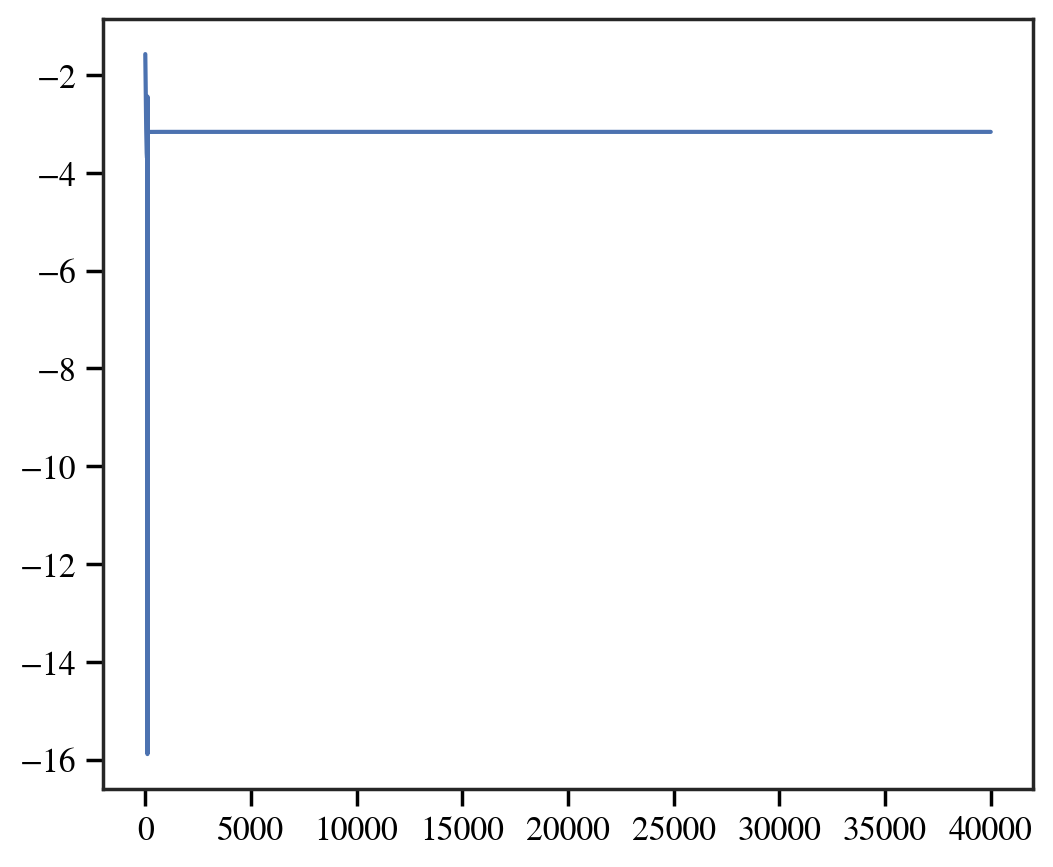

In [153]:
plt.plot(alpha1)

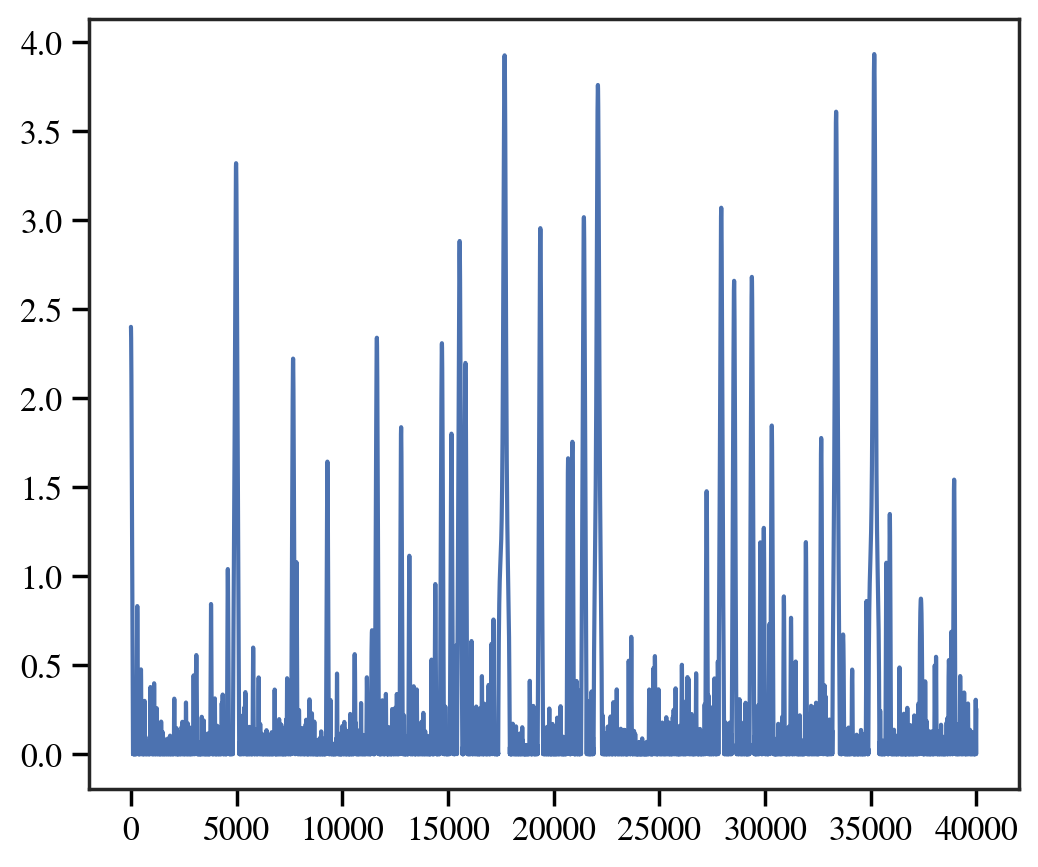

In [148]:
plt.plot(r1)